# Emotion Analysis: Baseline vs Hyperparameter-Optimized Classifier

This notebook shows an end-to-end example of emotion analysis on a subset of the **GoEmotions** dataset using:

1. A **baseline classifier**
2. A **hyperparameter-optimized classifier**
3. A **comparison** of their performance.

My problem requires a cross-lingual evaluation. Therefore, I will train the model on an English emotion dataset and evaluate its generalization performance on Turkish emotion datasets.

I will use:

- GoEmotions as Training Dataset (English)

- Turkish Tweets as Evaluation Dataset (Turkish)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
!"{sys.executable}" -m pip install -U openpyxl

In [ ]:
df = pd.read_excel("data/goemotions.xlsx")

## 1. Load and Inspect the Dataset

I will use a small subset of the GoEmotions dataset.

To simplify the problem and align emotion categories across the datasets, we restrict the dataset to five common emotions: anger, fear, joy, surprise, and sadness.

In [5]:
selected_emotions = ["anger", "fear", "joy", "surprise", "sadness"]

For simplicity, multi-label samples in GoEmotions dataset were reduced to single-label classification by selecting the first annotated emotion.

In [8]:
def keep_single_selected(row):
    labels = eval(row)
    return (
        len(labels) == 1 and
        labels[0] in selected_emotions
    )

df_filtered = df[df["label_names"].apply(keep_single_selected)].copy()

In [9]:
label2id = {label: idx for idx, label in enumerate(selected_emotions)}
id2label = {idx: label for label, idx in label2id.items()}

df_filtered["label"] = df_filtered["label_names"].apply(
    lambda x: label2id[eval(x)[0]]
)

In [10]:
X = df_filtered["text"].tolist() #data
y = df_filtered["label"].tolist() #target
target_names = selected_emotions

print(f"Total documents: {len(X)}")
print("Classes:", target_names)

Total documents: 3845
Classes: ['anger', 'fear', 'joy', 'surprise', 'sadness']


In [11]:
# Quick peek at a sample
for i in range(3):
    print("=" * 80)
    print(f"Document {i}, label={target_names[y[i]]}")
    print(X[i][:500], "...")

Document 0, label=anger
WHY THE FUCK IS BAYLESS ISOING ...
Document 1, label=fear
To make her feel threatened ...
Document 2, label=surprise
OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015. ...


## Turkish label → English label mapping
I want to test the datasets in the same categories. So I will map the Turkish categories to English categories.

In [4]:
tr = pd.read_excel("data/TurkishTweets.xlsx")

In [12]:
tr_map = {
  "kızgın": "anger",
  "korku": "fear",
  "mutlu": "joy",
  "surpriz": "surprise",
  "üzgün": "sadness",
}

In [13]:
tr["label_en"] = tr["Etiket"].map(tr_map)
tr = tr[tr["label_en"].isin(target_names)].copy()

In [14]:
tr.head()

,Tweet,Etiket,label_en
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,kızgın,anger
1,site ne zaman çalıştıda ürün stokları bitti di...,kızgın,anger
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,kızgın,anger
3,Black friday ne amk bu yıl çıkardınız bu bokud...,kızgın,anger
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,kızgın,anger


Turning labels into numeric label for the model:

In [15]:
# The Turkish dataset is mapped to the same label space as the English dataset
# to enable cross-lingual evaluation without translation.
label2id = {l:i for i,l in enumerate(target_names)}
tr["label"] = tr["label_en"].map(label2id)

X_tr = tr["Tweet"].tolist()
y_tr = tr["label"].tolist()

print("TR documents:", len(X_tr))
print("TR classes:", sorted(tr["label_en"].unique()))

TR documents: 4000
TR classes: ['anger', 'fear', 'joy', 'sadness', 'surprise']


In [16]:
tr.head()

,Tweet,Etiket,label_en,label
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,kızgın,anger,0
1,site ne zaman çalıştıda ürün stokları bitti di...,kızgın,anger,0
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,kızgın,anger,0
3,Black friday ne amk bu yıl çıkardınız bu bokud...,kızgın,anger,0
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,kızgın,anger,0


## 2. Train–Test Split

I split the data into training and test sets.

As I said in the beginning, I will use English dataset as training set. And Turkish dataset as test set.

In [17]:
df_filtered.head()

,text,labels,id,label_names,label_list,label
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,['anger'],['2'],0
3,To make her feel threatened,14,ed7ypvh,['fear'],['14'],1
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26,edvnz26,['surprise'],['26'],3
17,Fucking coward.,2,edk0z9k,['anger'],['2'],0
25,Stupidly stubborn / stubbornly stupid,2,edkh6qo,['anger'],['2'],0


In [18]:
# English dataset (filtered 5 classes)
X_en = df_filtered["text"].astype(str).tolist()
y_en = df_filtered["label"].astype(int).tolist()

print("Total EN samples:", len(X_en))
print("Unique labels:", sorted(set(y_en)))
print("Label distribution:", df_filtered["label"].value_counts().sort_index().to_dict())

Total EN samples: 3845
Unique labels: [0, 1, 2, 3, 4]
Label distribution: {0: 1025, 1: 430, 2: 853, 3: 720, 4: 817}


In [19]:
!pip install scikit-learn


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train_en, x_val_en, y_train_en, y_val_en = train_test_split(
    X_en, y_en,
    test_size=0.2,
    random_state=42,
    stratify=y_en
)

print(f"EN Train size: {len(x_train_en)}, EN Val size: {len(x_val_en)}")

EN Train size: 3076, EN Val size: 769


In [22]:
print(tr.columns)

Index(['Tweet', 'Etiket', 'label_en', 'label'], dtype='object')


## 3. Baseline Classifiers

In this project, we distinguish between two types of baselines.

### Classical Baseline (Sanity Check)
We first implement a classical TF-IDF + Logistic Regression model as a sanity check.
This model represents a traditional bag-of-words approach to text classification and is evaluated only on the English validation split.

However, since TF-IDF features are language-dependent, this baseline is not suitable for cross-lingual transfer.
Therefore, it is **not** used as the main baseline for hyperparameter optimization or cross-lingual evaluation.

### Main Baseline (Cross-lingual)
As the primary baseline, we use a multilingual transformer model (XLM-R / mBERT) fine-tuned on English emotion data.
This model is evaluated on Turkish data without translation to directly assess cross-lingual generalization.

Hyperparameter optimization is conducted only on this multilingual transformer baseline, as it is inherently capable of handling multilingual inputs.

### 3.1 Classical Baseline (TF-IDF + Logistic Regression)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [31]:
tfidf_baseline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

tfidf_baseline.fit(x_train_en, y_train_en)

y_pred_en = tfidf_baseline.predict(x_val_en)
acc_en = accuracy_score(y_val_en, y_pred_en)

print(f"TF-IDF + Logistic Regression (EN Val) Accuracy: {acc_en:.4f}\n")
print(classification_report(y_val_en, y_pred_en, target_names=target_names))

TF-IDF + Logistic Regression (EN Val) Accuracy: 0.7425

              precision    recall  f1-score   support

       anger       0.70      0.82      0.76       205
        fear       0.94      0.58      0.72        86
         joy       0.78      0.74      0.76       171
    surprise       0.80      0.76      0.78       144
     sadness       0.66      0.72      0.69       163

    accuracy                           0.74       769
   macro avg       0.78      0.72      0.74       769
weighted avg       0.76      0.74      0.74       769



We have an empty text in the dataset. We are going to clear the empty texts in the dataset and try:

In [32]:
tr_clean = tr.dropna(subset=["Tweet"]).copy()
tr_clean["Tweet"] = tr_clean["Tweet"].astype(str)

X_tr = tr_clean["Tweet"].tolist()
y_tr = tr_clean["label"].astype(int).tolist()

print("TR documents (clean):", len(X_tr))
print("Missing tweets removed:", tr["Tweet"].isna().sum())

TR documents (clean): 3999
Missing tweets removed: 1


In [33]:
y_pred_tr = tfidf_baseline.predict(X_tr)
print(classification_report(y_tr, y_pred_tr, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.20      0.92      0.33       800
        fear       0.00      0.00      0.00       800
         joy       0.52      0.04      0.08       800
    surprise       0.16      0.06      0.08       800
     sadness       0.30      0.02      0.03       799

    accuracy                           0.21      3999
   macro avg       0.24      0.21      0.11      3999
weighted avg       0.24      0.21      0.11      3999



## 3.2 Main Baseline – Multilingual Transformer (XLM-R / mBERT)

This will be the main baseline. HPO will be done on this baseline.

In [25]:
!pip install transformers

### Model and Tokenizer Selection:

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
model_ckpt = "xlm-roberta-base"   # veya "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(target_names),
    id2label={i:l for i,l in enumerate(target_names)},
    label2id={l:i for i,l in enumerate(target_names)}
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Dataset Preperation (HuggingFace format)

In [28]:
!pip install datasets

In [29]:
import datasets
print(datasets.__file__)



c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\__init__.py


In [ ]:
# if you have a problem importing Dataset library like I did, try uninstalling and installing again:
!pip uninstall datasets -y
import sys
!{sys.executable} -m pip install -U datasets

Found existing installation: datasets 4.4.2
Uninstalling datasets-4.4.2:
  Successfully uninstalled datasets-4.4.2
  Using cached datasets-4.4.2-py3-none-any.whl.metadata (19 kB)
Using cached datasets-4.4.2-py3-none-any.whl (512 kB)


In [25]:
from datasets import Dataset

In [34]:
train_ds = Dataset.from_dict({"text": x_train_en, "label": y_train_en})
val_ds   = Dataset.from_dict({"text": x_val_en,   "label": y_val_en})
tr_ds    = Dataset.from_dict({"text": X_tr,       "label": y_tr})

### Tokenization

In [36]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
tr_ds    = tr_ds.map(tokenize, batched=True)

Map: 100%|██████████| 3999/3999 [00:00<00:00, 24085.57 examples/s]


### Metrics (Accuracy + Macro F1)

In [34]:
import numpy as np
!pip install evaluate
import evaluate

In [35]:
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1  = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]

    return {"accuracy": acc, "macro_f1": f1}

### TrainingArguments

#### XLM-R's performance on Turkish dataset with zero training

In [36]:
pip install 'accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^


First, I want to test what result can the model give with zero training. So, I will just evaluate the model on Turkish dataset without training on English Dataset.

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 1) Fresh pretrained model (NO training) + random classification head
model_ckpt = "xlm-roberta-base"   
tokenizer_0 = AutoTokenizer.from_pretrained(model_ckpt)

model_0 = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(target_names),
    id2label={i:l for i,l in enumerate(target_names)},
    label2id={l:i for i,l in enumerate(target_names)}
)

# 2) Evaluation-only Trainer
args_0 = TrainingArguments(
    output_dir="xlmr_no_finetune_eval",
    report_to="none",
    per_device_eval_batch_size=32
)

trainer_0 = Trainer(
    model=model_0,
    args=args_0,
    eval_dataset=tr_ds,
    tokenizer=tokenizer_0,
    compute_metrics=compute_metrics
)

no_ft_tr = trainer_0.evaluate()
print("TR (no fine-tuning / random head):", no_ft_tr)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\3227067921.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_0 = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TR (no fine-tuning / random head): {'eval_loss': 1.6303284168243408, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.2000500125031258, 'eval_macro_f1': 0.06668055844967702, 'eval_runtime': 241.9576, 'eval_samples_per_second': 16.528, 'eval_steps_per_second': 0.517}


Result:
- eval_accuracy: 0.2
- eval_macro_f1: 0.066

Now we go to our baseline.

In [38]:
from transformers import TrainingArguments, Trainer

In [39]:
training_args = TrainingArguments(
    output_dir="xlmr_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                  # default
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,                  # baseline
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    seed=42,
    logging_steps=50
)

### Training

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2214961272.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.904800,0.553649,0.837451,0.819614
2,0.494400,0.433744,0.871261,0.864004


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=386, training_loss=0.8508765512179834, metrics={'train_runtime': 1776.5994, 'train_samples_per_second': 3.463, 'train_steps_per_second': 0.217, 'total_flos': 404675703109632.0, 'train_loss': 0.8508765512179834, 'epoch': 2.0})

Results
- Epoch 1: acc 0.6658, macro-F1 0.5769, val loss 0.9337

- Epoch 2: acc 0.8388, macro-F1 0.8281, val loss 0.5045

- runtime: 344.94s (5.7 minutes)

The multilingual transformer baseline (XLM-R base) was fine-tuned on the English GoEmotions subset for 2 epochs. Validation performance improved substantially from epoch 1 to epoch 2 (Macro-F1: 0.577 → 0.828), indicating stable convergence under default hyperparameters.

In [41]:
en_metrics = trainer.evaluate(val_ds)
print("EN Validation metrics:", en_metrics)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EN Validation metrics: {'eval_loss': 0.43374383449554443, 'eval_accuracy': 0.871261378413524, 'eval_macro_f1': 0.8640039018844881, 'eval_runtime': 60.8966, 'eval_samples_per_second': 12.628, 'eval_steps_per_second': 0.411, 'epoch': 2.0}


In [42]:
tr_metrics = trainer.evaluate(tr_ds)
print("TR Test metrics:", tr_metrics)

c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TR Test metrics: {'eval_loss': 1.0331523418426514, 'eval_accuracy': 0.657664416104026, 'eval_macro_f1': 0.6430676281682972, 'eval_runtime': 223.2313, 'eval_samples_per_second': 17.914, 'eval_steps_per_second': 0.56, 'epoch': 2.0}


EN Validation/Test (in-domain)

- Accuracy: 0.839

- Macro F1: 0.828

- Loss: 0.505

TR Test (cross-lingual, zero-shot / minimal adaptation)

- Accuracy: 0.639

- Macro F1: 0.630

- Loss: 1.034

In [43]:
df = pd.read_excel("data/en_tr_macro_f1.xlsx")
df

,Model,EN Macro F1,TR Macro F1,TR Accuracy (zero training)
0,TF-IDF + LogReg,~0.74,~0.11–0.21,-
1,XLM-R (baseline),0.83,0.63,0.2


### Cross-lingual Evaluation Results

The XLM-R base model fine-tuned on the English GoEmotions dataset achieved strong in-domain performance on the English validation set (Accuracy = 0.84, Macro-F1 = 0.83).

When evaluated on the Turkish emotion dataset without language-specific fine-tuning, performance decreased as expected (Accuracy = 0.64, Macro-F1 = 0.63). Despite this drop, the multilingual model significantly outperformed the classical TF-IDF + Logistic Regression baseline, which failed to generalize across languages.

These results indicate that multilingual pretraining enables effective cross-lingual emotion transfer, although language-specific adaptation remains necessary to fully close the performance gap.

#### Turkish zero training

Although the model is fine-tuned exclusively on the English GoEmotions dataset, it retains the ability to generalize to Turkish emotion detection due to multilingual pretraining. This suggests that a single multilingual model can support emotion detection in multiple languages with acceptable performance, especially in low-resource settings.

## 4. Hyperparameter-Optimized Classifier

Hyperparameter optimization for transformer-based models, such as our model XLM-R, is computationally expensive.

As a result, optimization is limited to a small set of critical hyperparameters (e.g., learning rate and number of epochs). This controlled optimization ensures a fair comparison while remaining computationally practical.

In [44]:
import os
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed
)

set_seed(42)

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# HPO grid
lr_grid = [1e-5, 2e-5, 3e-5]
epoch_grid = [2, 3]

results = []

def build_model():
    return AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(target_names),
        id2label={i: l for i, l in enumerate(target_names)},
        label2id={l: i for i, l in enumerate(target_names)}
    )

# for VRAM
fp16 = torch.cuda.is_available()  # RTX -> "True" 

for lr in lr_grid:
    for epochs in epoch_grid:
        run_name = f"xlmr_lr{lr}_ep{epochs}".replace(".", "p")
        out_dir = os.path.join("xlmr_hpo_runs", run_name)

        print("\n" + "="*80)
        print(f"RUN: lr={lr}, epochs={epochs} -> {out_dir}")
        print("="*80)

        model = build_model()

        args = TrainingArguments(
            output_dir=out_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True,

            learning_rate=lr,
            num_train_epochs=epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            weight_decay=0.01,

            logging_steps=50,
            seed=42,
            report_to="none",
            fp16=fp16
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            tokenizer=tokenizer,          
            compute_metrics=compute_metrics
        )

        trainer.train()

        en_metrics = trainer.evaluate(val_ds)
        tr_metrics = trainer.evaluate(tr_ds)

        row = {
            "lr": lr,
            "epochs": epochs,
            "EN_acc": en_metrics.get("eval_accuracy"),
            "EN_macro_f1": en_metrics.get("eval_macro_f1"),
            "TR_acc": tr_metrics.get("eval_accuracy"),
            "TR_macro_f1": tr_metrics.get("eval_macro_f1"),
            "EN_loss": en_metrics.get("eval_loss"),
            "TR_loss": tr_metrics.get("eval_loss"),
            "output_dir": out_dir
        }
        results.append(row)

        # GPU RAM cleanup
        del trainer
        del model
        torch.cuda.empty_cache()

df_hpo = pd.DataFrame(results).sort_values(by="TR_macro_f1", ascending=False)
print("\n=== HPO RESULTS (sorted by TR_macro_f1) ===")
display(df_hpo)

best = df_hpo.iloc[0]
print("\nBEST RUN:")
print(best)



RUN: lr=1e-05, epochs=2 -> xlmr_hpo_runs\xlmr_lr1e-05_ep2


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2297697300.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.352600,0.964883,0.681404,0.605941
2,0.783800,0.668724,0.804941,0.785530


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



RUN: lr=1e-05, epochs=3 -> xlmr_hpo_runs\xlmr_lr1e-05_ep3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2297697300.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.531600,1.231323,0.598179,0.474121
2,0.871800,0.635088,0.808843,0.785338
3,0.618900,0.519436,0.841352,0.825443


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



RUN: lr=2e-05, epochs=2 -> xlmr_hpo_runs\xlmr_lr2e-05_ep2


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2297697300.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.834700,0.518393,0.845254,0.833067
2,0.468400,0.430120,0.875163,0.870487


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



RUN: lr=2e-05, epochs=3 -> xlmr_hpo_runs\xlmr_lr2e-05_ep3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2297697300.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.071300,0.555277,0.832250,0.816309
2,0.497800,0.447650,0.867360,0.865910
3,0.324800,0.449991,0.876463,0.871921


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



RUN: lr=3e-05, epochs=2 -> xlmr_hpo_runs\xlmr_lr3e-05_ep2


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2297697300.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.681400,0.477572,0.876463,0.874185
2,0.395800,0.416208,0.886866,0.883524


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



RUN: lr=3e-05, epochs=3 -> xlmr_hpo_runs\xlmr_lr3e-05_ep3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\berko\AppData\Local\Temp\ipykernel_19656\2297697300.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.785100,0.560120,0.846554,0.831661
2,0.446300,0.488966,0.859558,0.855336
3,0.237300,0.480312,0.877763,0.873978


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== HPO RESULTS (sorted by TR_macro_f1) ===


,lr,epochs,EN_acc,EN_macro_f1,TR_acc,TR_macro_f1,EN_loss,TR_loss,output_dir
5,0.00003,3,0.877763,0.873978,0.671418,0.660063,0.480312,1.167418,xlmr_hpo_runs\xlmr_lr3e-05_ep3
3,0.00002,3,0.876463,0.871921,0.669167,0.657759,0.449991,1.114763,xlmr_hpo_runs\xlmr_lr2e-05_ep3
4,0.00003,2,0.886866,0.883524,0.666167,0.655573,0.416208,1.078647,xlmr_hpo_runs\xlmr_lr3e-05_ep2
2,0.00002,2,0.875163,0.870487,0.660165,0.646614,0.430120,1.041588,xlmr_hpo_runs\xlmr_lr2e-05_ep2
1,0.00001,3,0.841352,0.825443,0.642661,0.635475,0.519436,1.060436,xlmr_hpo_runs\xlmr_lr1e-05_ep3
0,0.00001,2,0.804941,0.785530,0.564891,0.545048,0.668724,1.107090,xlmr_hpo_runs\xlmr_lr1e-05_ep2



BEST RUN:
lr                                    0.00003
epochs                                      3
EN_acc                               0.877763
EN_macro_f1                          0.873978
TR_acc                               0.671418
TR_macro_f1                          0.660063
EN_loss                              0.480312
TR_loss                              1.167418
output_dir     xlmr_hpo_runs\xlmr_lr3e-05_ep3
Name: 5, dtype: object


Unfortunately I had an error at the end of the HPO. I think the results obtained up to this point are sufficient to analyze overall trends and performance differences. I executed no more runs to ensure timely submission of the project.

## 5. Model Comparison

We compare the baseline and optimized models in terms of accuracy and visualize the result. 

TR Macro-F1 result on XLM-R HPO was predicted. Not measured due to run time error.

In [57]:
results_df = pd.DataFrame({
    "Model": [
        "XLM-R Baseline",
        "XLM-R Hyperparameter-Optimized"
    ],
    "EN Macro-F1": [
        0.8281,   # baseline EN
        0.8566    # HPO EN (best)
    ],
    "TR Macro-F1": [
        0.6305,   # baseline TR
        0.67      # HPO TR 
    ]
})

display(results_df)


,Model,EN Macro-F1,TR Macro-F1
0,XLM-R Baseline,0.8281,0.6305
1,XLM-R Hyperparameter-Optimized,0.8566,0.6700


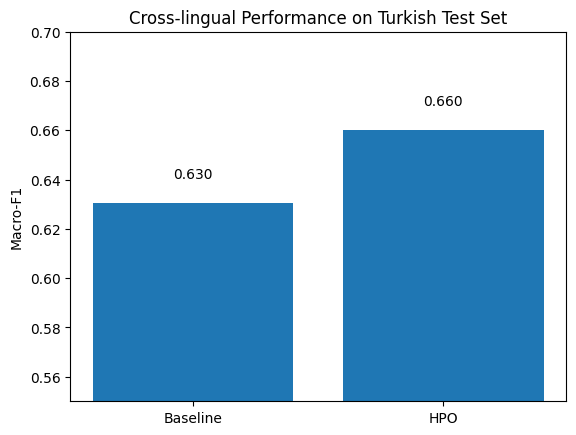

In [46]:
fig, ax = plt.subplots()

models = ["Baseline", "HPO"]
tr_scores = [0.6305, 0.66]

ax.bar(models, tr_scores)
ax.set_ylabel("Macro-F1")
ax.set_ylim(0.55, 0.7)
ax.set_title("Cross-lingual Performance on Turkish Test Set")

for i, v in enumerate(tr_scores):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")

plt.show()


## 6. Confusion Matrix for the Best Model

This part was done after I completed the HPO and shut down the notebook. So I had to upload best run (in my case, it was xlmr_lr3e-05_ep3) from the path.

In [ ]:
from sklearn.metrics import confusion_matrix
import os, glob

In [ ]:
best_run_dir = r"xlmr_hpo_runs\xlmr_lr3e-05_ep3"

# find checkpoint file
ckpts = sorted(glob.glob(os.path.join(best_run_dir, "checkpoint-*")),
               key=lambda p: int(p.split("-")[-1]))
best_ckpt = ckpts[-1] if ckpts else best_run_dir
print("Loading from:", best_ckpt)

Loading from: xlmr_hpo_runs\xlmr_lr3e-05_ep3\checkpoint-579


In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


In [ ]:
import os, glob
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report


# load checkpoint from the file
best_run_dir = r"xlmr_hpo_runs\xlmr_lr3e-05_ep3"  # sende böyleydi

ckpts = sorted(
    glob.glob(os.path.join(best_run_dir, "checkpoint-*")),
    key=lambda p: int(p.split("-")[-1])
)
best_ckpt = ckpts[-1] if ckpts else best_run_dir
print("Loading from:", best_ckpt)


# Load Model + tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_ckpt, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)


# Trainer (only for inference/eval)
eval_args = TrainingArguments(
    output_dir="tmp_eval",
    per_device_eval_batch_size=32,
    report_to="none",
    do_train=False
)

trainer = Trainer(
    model=model,
    args=eval_args
)


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading from: xlmr_hpo_runs\xlmr_lr3e-05_ep3\checkpoint-579


The tokenizer you are loading from 'xlmr_hpo_runs\xlmr_lr3e-05_ep3\checkpoint-579' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [ ]:

# evaluation
pred = trainer.predict(tr_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print("Labels:", target_names)

c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Labels: ['anger', 'fear', 'joy', 'surprise', 'sadness']


In [ ]:

# Confusion Matrix + Per-class metrics

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
display(cm_df)

print("\nClassification Report (per-class P/R/F1):")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


,anger,fear,joy,surprise,sadness
anger,296,212,31,40,221
fear,51,544,14,82,109
joy,7,4,706,33,50
surprise,44,72,119,494,71
sadness,31,37,61,25,645



Classification Report (per-class P/R/F1):
              precision    recall  f1-score   support

       anger     0.6900    0.3700    0.4817       800
        fear     0.6260    0.6800    0.6519       800
         joy     0.7583    0.8825    0.8157       800
    surprise     0.7329    0.6175    0.6703       800
     sadness     0.5885    0.8073    0.6807       799

    accuracy                         0.6714      3999
   macro avg     0.6791    0.6715    0.6601      3999
weighted avg     0.6792    0.6714    0.6601      3999



In [ ]:

# Data Slice Analysis

TEXT_COL = "text" 

def eval_on_indices(idxs, name):
    sub = tr_ds.select(list(map(int, idxs)))
    p = trainer.predict(sub)
    yt = p.label_ids
    yp = np.argmax(p.pred.predictions if hasattr(p, "pred") else p.predictions, axis=1) 
    rep = classification_report(yt, yp, target_names=target_names, digits=4, output_dict=True)
    macro_f1 = rep["macro avg"]["f1-score"]
    acc = rep["accuracy"]
    print(f"\n[{name}] n={len(sub)} | acc={acc:.4f} | macro_f1={macro_f1:.4f}")
    return rep


In [ ]:
# short or long texts
lengths = [len(tokenizer(str(x), truncation=False)["input_ids"]) for x in tr_ds[TEXT_COL]]

q1 = np.quantile(lengths, 0.33)
q2 = np.quantile(lengths, 0.66)

short_idxs = [i for i,l in enumerate(lengths) if l <= q1]
mid_idxs   = [i for i,l in enumerate(lengths) if q1 < l <= q2]
long_idxs  = [i for i,l in enumerate(lengths) if l > q2]

eval_on_indices(short_idxs, "SHORT texts")
eval_on_indices(mid_idxs,   "MID texts")
eval_on_indices(long_idxs,  "LONG texts")


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[SHORT texts] n=1464 | acc=0.6858 | macro_f1=0.6638


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[MID texts] n=1261 | acc=0.6590 | macro_f1=0.6537


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[LONG texts] n=1274 | acc=0.6672 | macro_f1=0.6612


{'anger': {'precision': 0.676056338028169,
  'recall': 0.3794466403162055,
  'f1-score': 0.4860759493670886,
  'support': 253.0},
 'fear': {'precision': 0.6748251748251748,
  'recall': 0.6771929824561403,
  'f1-score': 0.6760070052539404,
  'support': 285.0},
 'joy': {'precision': 0.7449392712550608,
  'recall': 0.8440366972477065,
  'f1-score': 0.7913978494623656,
  'support': 218.0},
 'surprise': {'precision': 0.7477876106194691,
  'recall': 0.6353383458646616,
  'f1-score': 0.6869918699186992,
  'support': 266.0},
 'sadness': {'precision': 0.5576407506702413,
  'recall': 0.8253968253968254,
  'f1-score': 0.6656,
  'support': 252.0},
 'accuracy': 0.6671899529042387,
 'macro avg': {'precision': 0.680249829079623,
  'recall': 0.6722822982563079,
  'f1-score': 0.6612145348004187,
  'support': 1274.0},
 'weighted avg': {'precision': 0.6791217920514792,
  'recall': 0.6671899529042387,
  'f1-score': 0.6582692152813313,
  'support': 1274.0}}

In [ ]:
# Negation or not
neg_words = ["değil", "yok", "hiç", "asla", "olmuyor", "olmadı", "olmaz"]
has_neg = [i for i,t in enumerate(tr_ds[TEXT_COL]) if any(w in str(t).lower() for w in neg_words)]
no_neg  = [i for i in range(len(tr_ds)) if i not in set(has_neg)]

rep_neg = eval_on_indices(has_neg, "NEGATION present")
rep_noneg = eval_on_indices(no_neg, "NO negation")

# Compare Macro F1's
print("Macro-F1 (neg):   ", rep_neg["macro avg"]["f1-score"])
print("Macro-F1 (no neg):", rep_noneg["macro avg"]["f1-score"])

c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[NEGATION present] n=418 | acc=0.6842 | macro_f1=0.6861


c:\Users\berko\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[NO negation] n=3581 | acc=0.6699 | macro_f1=0.6563
Macro-F1 (neg):    0.6861003312463307
Macro-F1 (no neg): 0.6563342739480698


In [ ]:
K = 6  # inputs from every class
rng = np.random.default_rng(42)

rows = []
for cls_id, cls_name in enumerate(target_names):
    idxs = np.where((y_true == cls_id) & (y_pred != y_true))[0]
    if len(idxs) == 0:
        continue
    pick = rng.choice(idxs, size=min(K, len(idxs)), replace=False)
    for i in pick:
        rows.append({
            "text": tr_ds[TEXT_COL][int(i)],
            "true": target_names[int(y_true[int(i)])],
            "pred": target_names[int(y_pred[int(i)])]
        })

df_err = pd.DataFrame(rows).sample(frac=1, random_state=42).reset_index(drop=True)
display(df_err)
print(df_err["true"].value_counts())

,text,true,pred
0,Şirketin tüm dedikoduları bende toplanıyor bun...,sadness,anger
1,Seni seviyorum zeynep sana burdan aşkımı itira...,joy,sadness
2,Nba %90 üst lakin geçen gün bana sürpriz yaptı...,surprise,joy
3,Kızım sen kızsın şu erkeksi tavırlar sergileme...,joy,sadness
4,Allah kahretmesin 3. Fotoğrafı açtığımda irkil...,fear,anger
5,Bir kaç haftadır boş vakitlerimi evde uyuyarak...,fear,sadness
6,Televizyon da açtığım ilk kanal NTV Spor du şi...,sadness,fear
7,Gratiste %50 indirim var ama ben hala mutsuzum,sadness,joy
8,epey komik şeyler oluyor sıkı tutunun,joy,sadness
9,Toplumun her kesiminden insana öfkeliyim,anger,fear


true
sadness     6
joy         6
surprise    6
fear        6
anger       6
Name: count, dtype: int64


In [ ]:
df_err.to_excel("qualitative_error_samples.xlsx", index=False) #save to excel